# Pattern Comparison of Frequency of DEG in ASD patients with or without Epilepsy and Tendency
<br/><br/>

## 1. Introduction

ASD는 그 자체로 상당히 힘든 질병이지만, ASD 환자들 중 상당 수가 Epilepsy도 동시에 관찰되고 있다. Epilepsy는 발작(Seizure)을 동반하여 발생하며 Epilepsy 환자 중 상당수가 갑작스럽게 죽음을 맞이하는 경우를 볼 수 있다.[data S1] 따라서 단순히 ASD만 가지고 있는 집단과 ASD와 Epilepsy를 모두 가지고 있는 집단들 사이에는 유전적 발현패턴에 차이가 있음을 유추해 볼 수 있다. 따라서 여기에서는 __data S4__ 의 __Individual Specific DEG__ 를 통해 환자 집단 사이에서 어떤 빈도로 DEG의 발현이 일어나는지 그 패턴을 보고자 했다. 또한 몇몇 DEG를 대상으로 fold change는 어느 정도 일어나는지를 보고자 했다. 

<br/><br/>
## 2. Pattern Comparison of Frequency of DEG in Each Patients Case and tendency for each cell group  
<br/><br/>
### 2.1. Data wrangling and Visulization
주어진 Individual Specific DEG의 특징은 각 gene에 대한 정량적인 정보 없이 DEG의 발현 방향이 control group과 비교했을 때 더 많이 발현되었는지 적게 발현되었는지 여부만을 보여주고 있다. 따라서 이러한 정량적 데이터의 부족을 극복하기 위해서 'ASD_patients_with_DE_signal' column의 환자를 ASD만 가진 환자와 ASD와 Epilepsy를 가진 환자로 분류하고 유전자별 DEG의 발현 횟수를 확인하였다. 발현 빈도는 각 환자의 case(ASD_only, ASD_Epilepsy)의 수로 나눠주어 구하였다. 그리고 upregulated case와 downregulated case를 구분하기 위해서 downregulated case의 경우 (-)부호를 붙여주었다. 


In [7]:
library(tidyverse)
library(readxl)
library(cowplot)
library(ggpubr)
library(ggrepel)

# Data load
ASD_DEG <- read_excel("C:/Users/withj/Rproject/aav8130_Data-S4.xlsx", sheet = 1)
ASD_sample <- read_excel("C:/Users/withj/Rproject/aav8130_Data-S1.xlsx", sheet = 1)
Ind_DEG <- read_excel("C:/Users/withj/Rproject/aav8130_Data-S4.xlsx", sheet = 4)



# ASD+Epilepsy Patient ID
a_id <- ASD_sample %>% filter(grepl("Epilepsy", ASD_sample$Other_diagnoses)) %>% .$Patient_ID

# code to get the number of patients for each patients case  
Ind_DEG %>% 
  separate_rows(ASD_patients_with_DE_signal) %>%
  mutate(patient_case = ifelse(ASD_patients_with_DE_signal %in% a_id,
                               "ASD_Epilepsy", "ASD_only")) %>%
  .$ASD_patients_with_DE_signal %>% unique() 

New names:
* `` -> ...9
* `` -> ...10
* `` -> ...11
* `` -> ...12



[1] "4849" "5531" "5565" "5864" "5939" "5978" "6033" "5403" "4899" "5945"
[11] "5144" "5419" "5841" "5278" "5294"

In [8]:
# wrangling
Ind_DEG1 <-Ind_DEG %>% 
  separate_rows(ASD_patients_with_DE_signal) %>%
  mutate(patient_case = ifelse(ASD_patients_with_DE_signal %in% a_id,
                               "ASD_Epilepsy", "ASD_only")) %>%
  group_by(Gene_name, patient_case) %>%
  count(`Direction_of_change_(ASD/Control)`) %>%
  merge(x =., y = select(ASD_DEG, Cell_type, Gene_name), by = "Gene_name") %>%
  mutate(n = ifelse(patient_case == "ASD_Epilepsy", n/8, n/7))%>%
  mutate(average_DEG = ifelse(`Direction_of_change_(ASD/Control)` == "DOWN", -n, n)) %>%
  mutate(col_id = paste(Cell_type, Gene_name, `Direction_of_change_(ASD/Control)`, sep="."))


Ind_DEG2 <- Ind_DEG1 %>% 
  select(col_id, patient_case, average_DEG) %>%
  spread(patient_case, average_DEG) %>%
  mutate(ASD_Epilepsy = replace_na(ASD_Epilepsy, 0)) %>%
  mutate(ASD_only = replace_na(ASD_only, 0)) %>%
  merge(x = ., y = Ind_DEG1 %>% select(col_id, Cell_type), 
        by = "col_id") %>%
  mutate(ratio = ASD_Epilepsy/ASD_only) %>%
  mutate(col_id2 = col_id)%>%
  separate(col_id2, c("Cell_type", "Gene_name", "Direction_of_FC"), sep="\\.") %>%
  mutate(col_id3 = paste(Cell_type, Gene_name, sep="_")) %>%
  unique()

#lines slop 4/5, 1, 5/4
d <- tibble::tribble(
  ~ID, ~b0, ~c,
  1L,  4/5, "range",
  2L,  1,   "standard",
  3L,  5/4, "range"
  )

Warning message:
"Expected 3 pieces. Additional pieces discarded in 22 rows [15, 16, 23, 24, 279, 280, 407, 408, 454, 455, 456, 457, 478, 479, 562, 563, 564, 565, 566, 567, ...]."


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



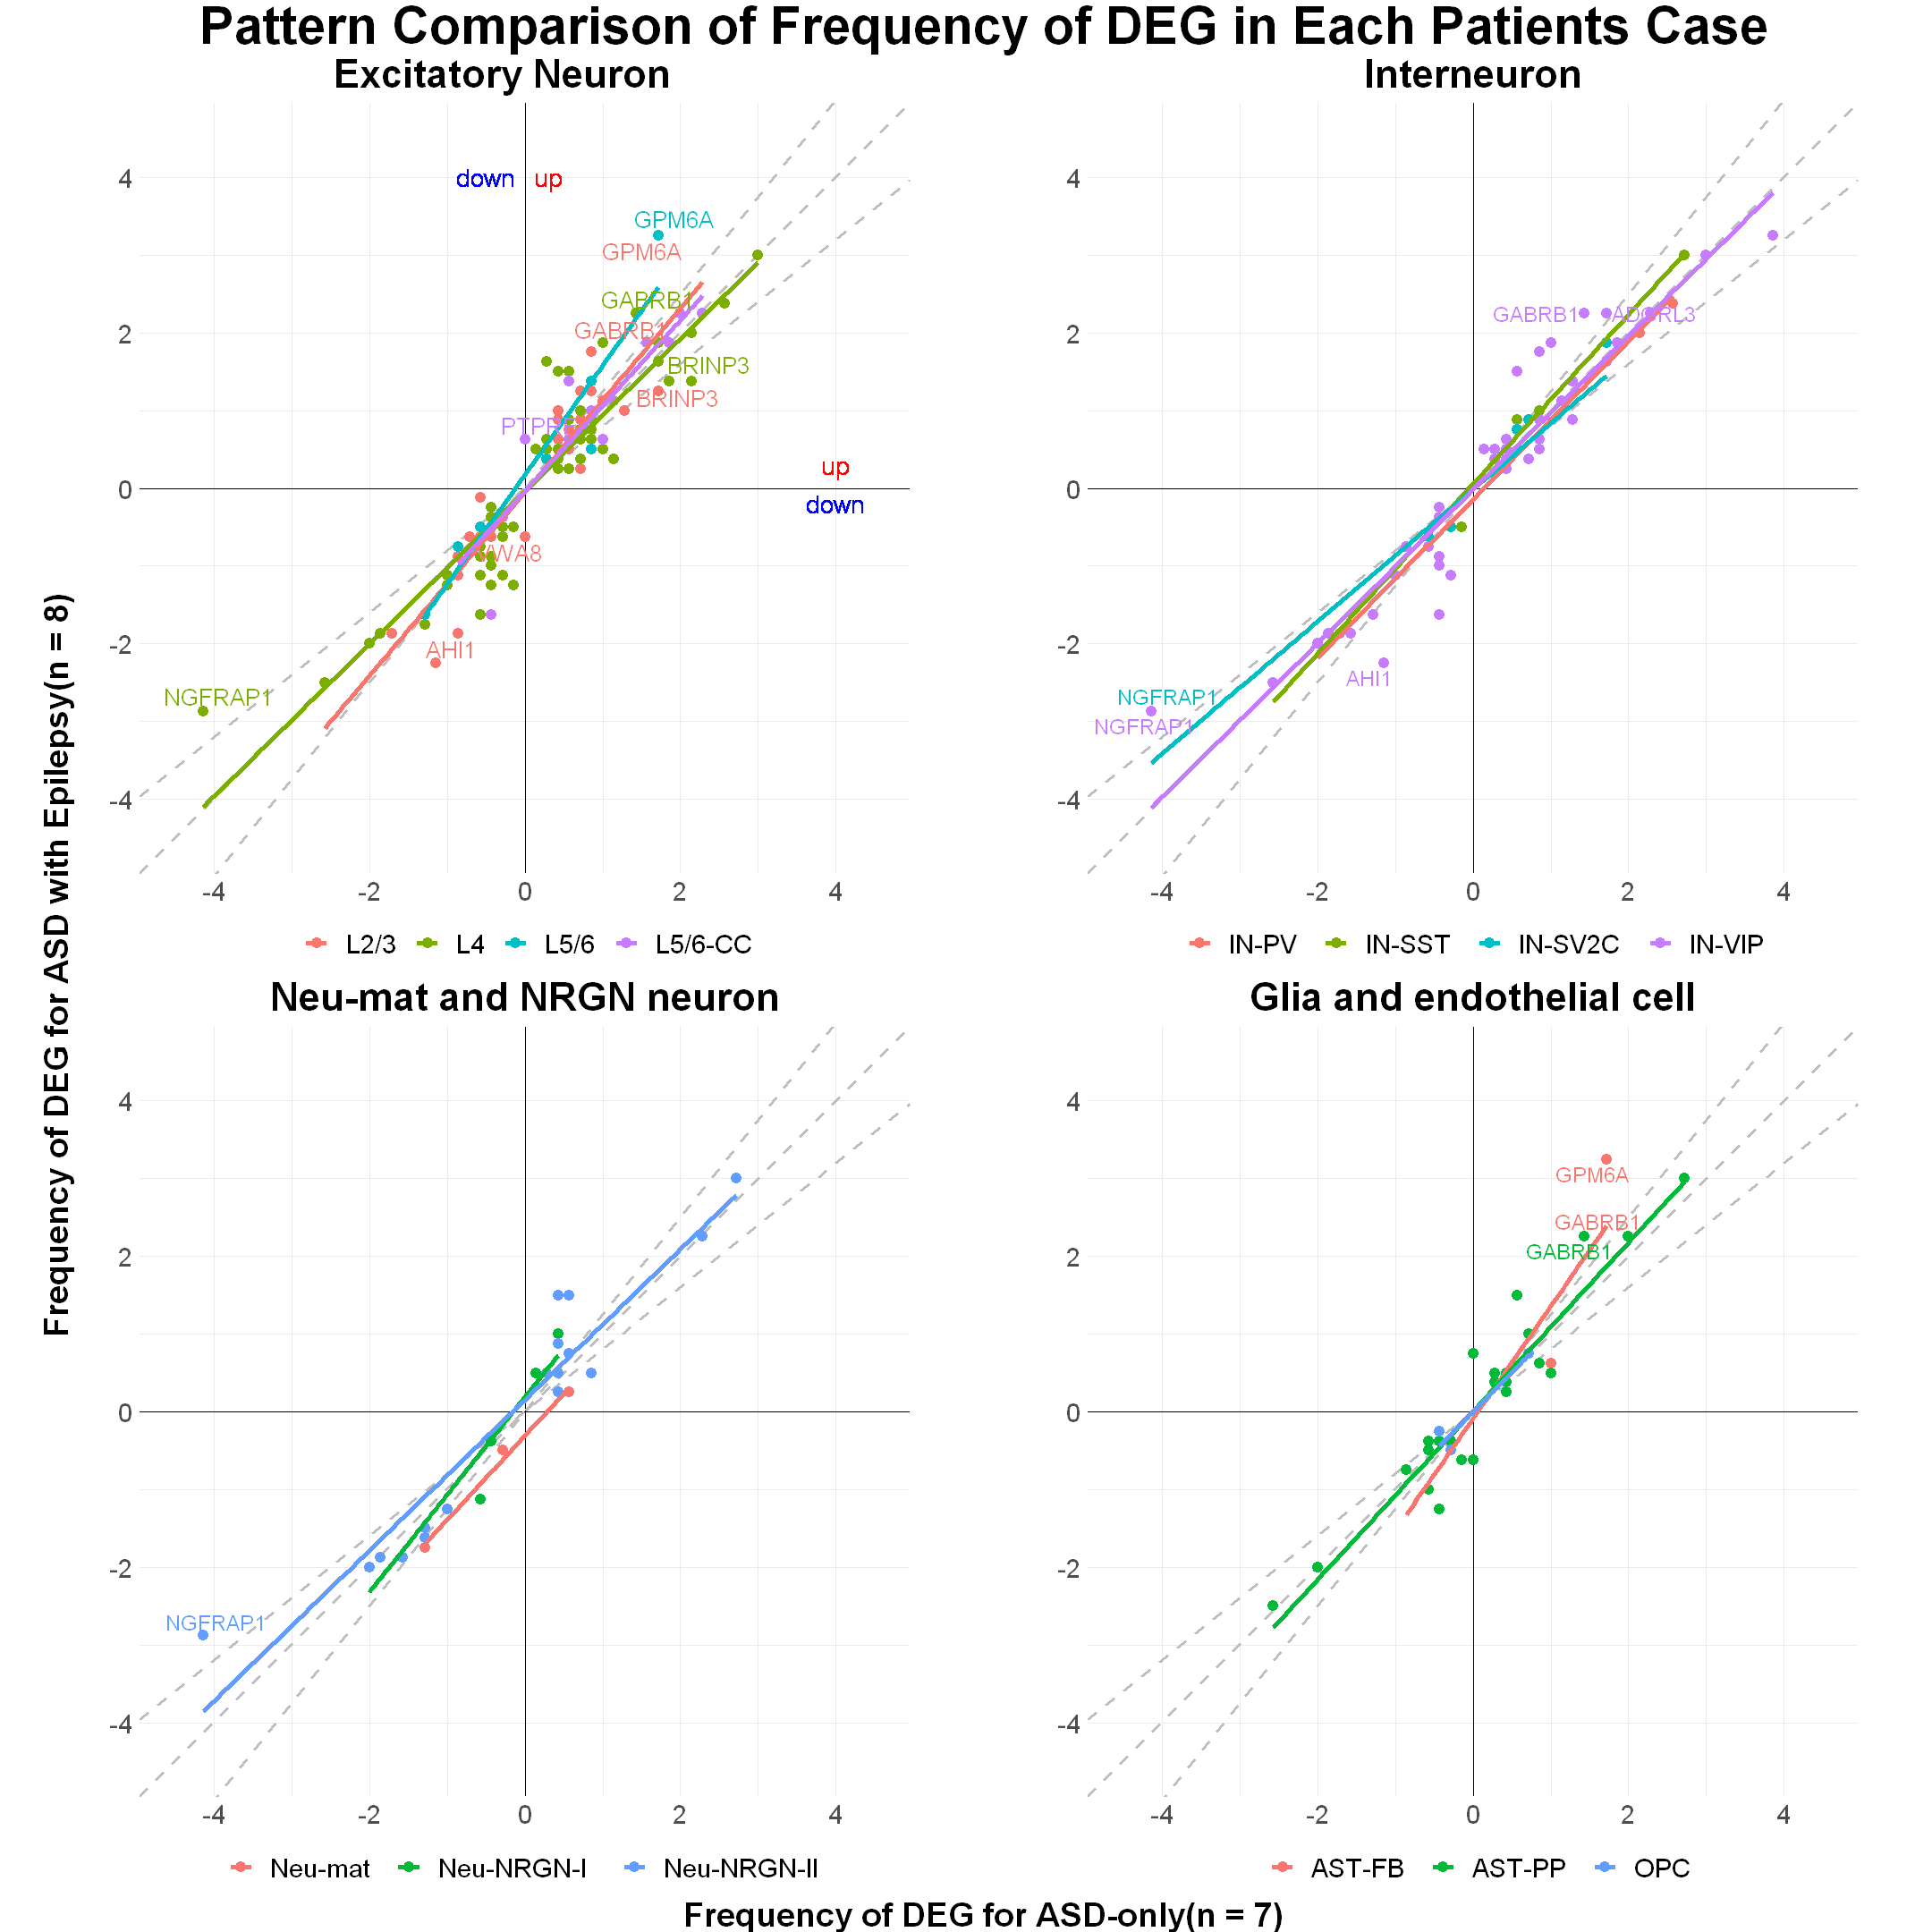

In [9]:
# plot code

options(repr.plot.width=18, repr.plot.height=18)

ggarrange(
Ind_DEG2 %>%
  filter(Cell_type %in% c("L2/3", "L4", "L5/6", "L5/6-CC")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(data = d, aes(slope = b0, intercept = 0, group = "ID"),
              color = "grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  geom_text_repel(aes(label = Gene_name), 
                   data = Ind_DEG2 %>%
                   filter(Cell_type %in% c("L2/3", "L4", "L5/6", "L5/6-CC")) %>%
                   filter(ratio> 5/4 | ratio< 4/5) %>%
                   filter(abs(ASD_Epilepsy) > 2 | abs(ASD_only) >2 | abs(ratio) == Inf) , 
                   show.legend = F, size = 5.5,)+
  geom_text(x = 4, y = 0.3, label = "up", size = 6, color= "red")+
  geom_text(x = 4, y = -0.2, label = "down", size = 6, color = "blue")+
  geom_text(x = 0.3, y = 4, label = "up", size = 6, color= "red")+
  geom_text(x = -0.5, y = 4, label = "down", size = 6, color = "blue")+
  coord_fixed(ratio = 1) +
  labs(title = "Excitatory Neuron") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.45, face = "bold"),
        text = element_text(size = 22),
        axis.title = element_blank(),
        legend.position = "bottom"), 
    
Ind_DEG2 %>%
  filter(Cell_type %in% c("IN-PV","IN-SST","IN-SV2C","IN-VIP")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(data = d, aes(slope = b0, intercept = 0, group = "ID"),
              color = "grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  geom_text_repel(aes(label = Gene_name), 
                   data = Ind_DEG2 %>%
                   filter(Cell_type %in% c("IN-PV","IN-SST","IN-SV2C","IN-VIP")) %>%
                   filter(ratio> 5/4 | ratio< 4/5) %>%
                   filter(abs(ASD_Epilepsy) > 2 | abs(ASD_only) >2), 
                   show.legend = F, size = 5)+
  coord_fixed(ratio = 1) +
  labs(title = "Interneuron") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"),
        text = element_text(size = 22),
        axis.title = element_blank(),
       legend.position = "bottom"),
    
Ind_DEG2 %>%
  filter(Cell_type %in% c("Neu-mat", "Neu-NRGN-I","Neu-NRGN-II")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy,, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(data = d, aes(slope = b0, intercept = 0, group = "ID"),
              color = "grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  geom_text_repel(aes(label = Gene_name), 
                   data = Ind_DEG2 %>%
                   filter(Cell_type %in% c("Neu-mat", "Neu-NRGN-I","Neu-NRGN-II")) %>%
                    filter(ratio> 5/4 | ratio< 4/5) %>%
                   filter(abs(ASD_Epilepsy) > 2 | abs(ASD_only) >2), 
                   show.legend = F, size = 5)+
  coord_fixed(ratio = 1) +
  labs(title = "Neu-mat and NRGN neuron") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"), 
        text = element_text(size = 22),
        axis.title = element_blank(),
       legend.position = "bottom"), 
    
Ind_DEG2 %>%
  filter(Cell_type %in% c("AST-FB","AST-PP", "OPC")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(data = d, aes(slope = b0, intercept = 0, group = "ID"),
              color = "grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  geom_text_repel(aes(label = Gene_name), 
                   data = Ind_DEG2 %>%
                   filter(Cell_type %in% c("AST-FB","AST-PP", "OPC")) %>%
                    filter(ratio> 5/4 | ratio< 4/5) %>%
                   filter(abs(ASD_Epilepsy) > 2 | abs(ASD_only) >2), 
                   show.legend = F, size = 5)+
  coord_fixed(ratio = 1) +
  labs(title = "Glia and endothelial cell") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"),
        text = element_text(size = 22),
        axis.title = element_blank(),
       legend.position = "bottom"),
ncol = 2, nrow = 2) %>%
annotate_figure(top = text_grob("Pattern Comparison of Frequency of DEG in Each Patients Case", 
                                face = "bold", size = 35),
                bottom = text_grob("Frequency of DEG for ASD-only(n = 7)", 
                                   face = "bold", size = 22),
                left = text_grob("Frequency of DEG for ASD with Epilepsy(n = 8)", 
                                 face = "bold", size = 22, rot = 90, vjust = 2))

   __Figure 1. Pattern Comparison of Frequency of DEG in Each Patients Case and tendency for each cell group__ 각 점은 DEG를 의미한다. 좌표평면의 제 1사분면은 모두 upregulated 된 경우, 제 3사분면은 모두 downregulated 된 경우를 의미하며, 제 2사분면과 제 4사분면은 두 case에서 상반된 dysregulation 방향을 보이는 경우를 의미함. 점선의 기울기는 각각 5/4, 1, 4/5로 기울기가 1인 점선을 기준으로 기울기가 커지면 Epilepsy를 가진 ASD 환자 집단 내에서 DEG 발현 빈도가 많다는 의미이고 기울기가 작으면 있으면 그 반대를 의미함. 

<br/><br/>
## 2.2. Discussion for Figure 1

위 그림을 통해 알 수 있는 점은 전체적으로 놓고 봤을 때에는 동일한 DEG에 대해서 발현 빈도(각 집단 내의 DEG 발견 횟수/각 집단의 환자 수)가 ASD with Epilepsy(AE)가 ASD-only(Ao)보다 상대적으로 높다고 볼 수 있다. 이를 더 과발현되었다고 해석할 수는 없지만 동일한 DEG를 가지는 횟수가 더 많은 경향을 보인다고 해석할 수 있고 이는 좀 ASD에 비해서 좀 더 공통적으로 공유하는 DEG가 많은 경향을 보인다고 생각할 수도 있다. 이는 어찌보면 좀 더 특이성을 가진 증상이기 때문에 당연한 결과일 수도 있다.  <br/><br/>
각각의 Cell group별로 보면 각 group에 따라서 발현 빈도 패턴이 다르게 나타닌다. 우선 Excitatory Neuron group을 보면 가장 많은 점들이 나타나있고 전체적으로 y = x 그래프보다 기울기가 큰 쪽에 더 많이 몰려있는 것을 통해서 Excitatory cell은 ASD with Epilepsy case에서 더 자주 나타남을 알 수 있다. 반면 다른 세포 그룹에서는 추세선이 y=x와 비슷한 기울기를 가지고 있다는 점을 통해 다른 Cell group들에서는 Ao group과 AE group 발현 빈도 패턴에서 비슷하다고 볼 수 있다. <br/><br/>
앞으로 Ao group과 AE group 사이의 연구를 해야 할 때 주목해볼만한 DEG는 아무래도 점선이 나타내는 기울기에서 크게 벗어난 점들이 아닐까 싶다. 원점과 각 점을 이은 직선의 기울기는 

$$\frac{frequency \ of \ DEG in \ AE}{frequency \ of \ DEG \ in \ Ao}$$

이고 이를 ratio of frequency(RF)라는 의미있는 지수로 설정하여 생각해 볼 수 있다. RF에 대해서 오차로 생각해 볼 수 있는 범위를 설정하고 그 범위 밖에 존재하는 gene들을 조사해 본다면 Ao group에서는 나타나지 않은 AE만의 특정 DEG나 그 반대에 해당하는 경우를 알아낼 수 있을 것이다. 위의 figure에서는 그 기준을 4/5~5/4로 임의로 정하였는데 그렇게 정한 이유는 두 DEG 발현 빈도가 다르다고 생각하는 지점이었기 때문이다. 임의로 정한 기준 Excitatory neuron group에서는 추세선을 통해서 볼 때는 드러나지 않았지만 L4와 L2/3의 DEG가 많이 존재한다는 것을 알 수 있다. Interneuron group에서는 IN-VIP의 일부 DEG에 집중해 볼 수 있다. 세 번째 그림에서는 Neu-NRGN-II가 마지막 group에서는 AST-FB와 AST-PP의 DEG를 추가로 조사해볼 수 있을 것이다. 특히 y축 상에 존재하는 점들은 Ao group에서는 나타나지 않았지만 AE group에서는 나타난 DEG이기 때문에 눈여겨 볼 필요가 있다.<br/><br/>
이러한 방식의 한계점은 환자의 수가 절대적으로 부족하여 현재로서는 특이해보이는 것들이 평균회귀될 수 있다는 점이다. 하지만 환자의 수가 많이 확보되어 이러한 방식으로 패턴을 구할 수 있다면 후에는 환자의 DEG 발현을 패턴과 대조하여 Epilepsy 가능성이 존재하는지도 파악할 수 있는 모델이 될 가능성도 존재한다. 

<br/><br/>
## 3. Relation between Fold Change and Ratio of Frequency

위의 과정들을 통해서 Ao에 비해서 AE에서 발현되는 DEG의 빈도수(RF)가 많은 경우가 있음을 확인 할 수 있다. 그런데 DEG의 발현 빈도수가 많은 것이 Fold change의 크기와 연관이 있을지 확인해보는 것도 필요하다고 생각했다. 원래 의도하고자 하던 방향은 한 개인에게서 나타나는 DEG의 발현 패턴이 AE인 경우와 Ao인 경우에 서로 다른지를 보는 것이었기 때문에 이렇게나마 간접적으로 보려고 하였다. 
<br/><br/>
## 3.1. Data wrangling

ASD_DEG에서는 single cell에서의 DEG들을 다루고 있는데, 여기에서 얻을 수 있는 DEG가 individual DEG의 종류보다 제한적이었다. 이는 아래 코드의 `merge` 부분과  `filter(Fold_change != "NA")`를 통해서 알 수 있는데, 따라서 일단은 ASD_DEG와 Ind_DEG2 모두에서 공통되는 gene을 대상으로 플롯을 그려보았다. 

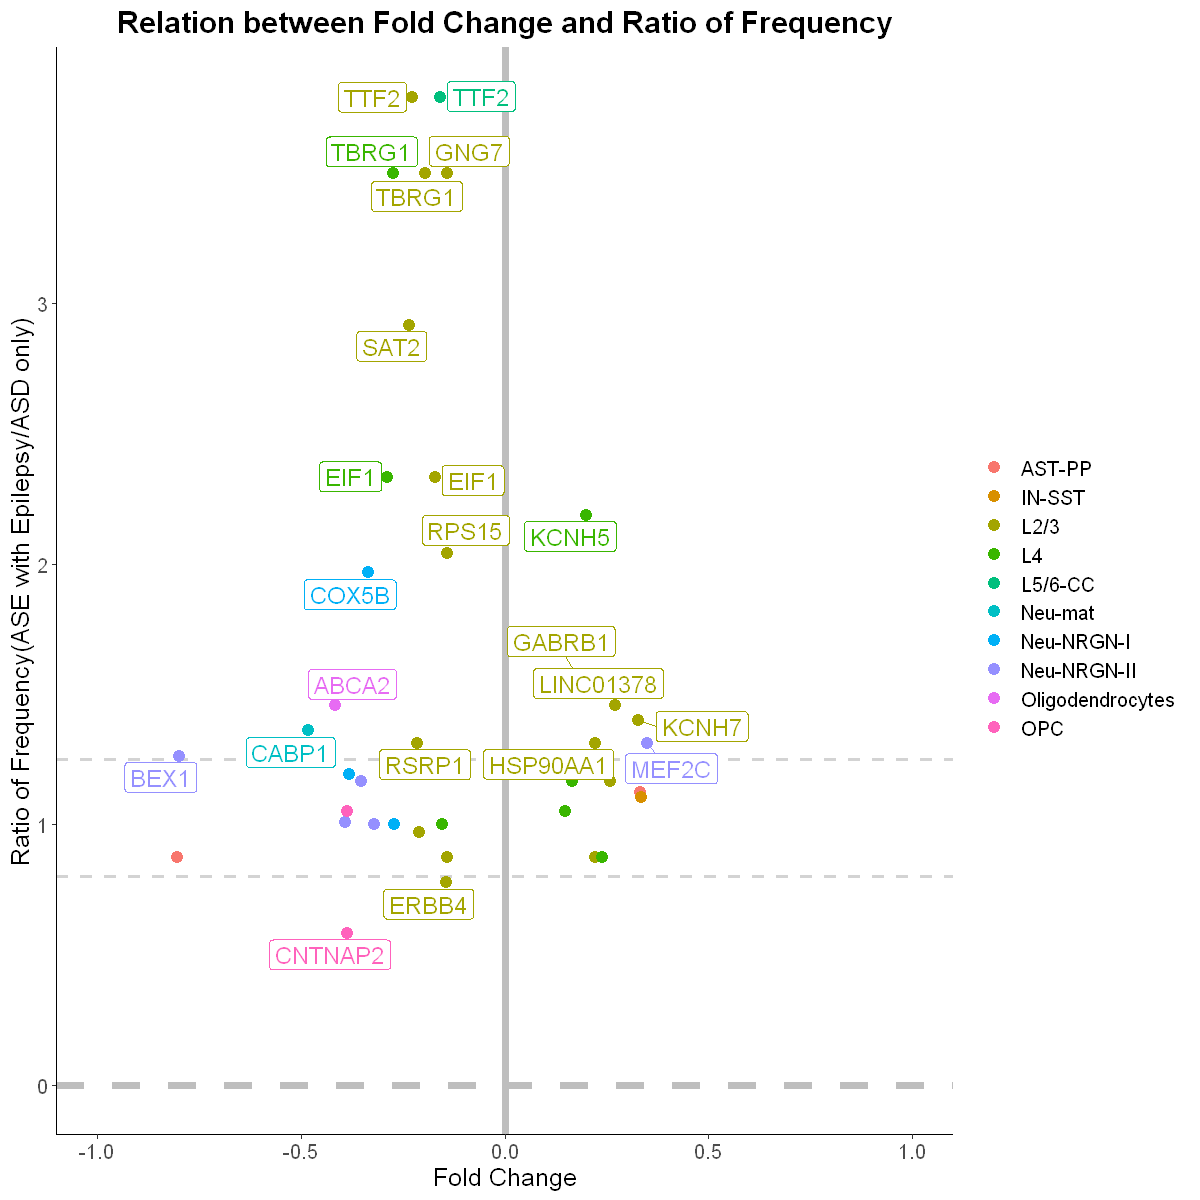

In [6]:
#ASDE_DEG: ASD DEG table 
ASDE_FC <- ASD_DEG %>%
  mutate(col_id3 = paste(Cell_type, Gene_name, sep="_"))%>%
  filter(col_id3 %in% Ind_DEG2$col_id3) %>% filter(Epilepsy_DEG == "yes") %>%
  select(Cell_type, Gene_name, Fold_change, q_value, col_id3)


#ratio of frequency and fold change of ASDE
rnf <- Ind_DEG2 %>%
  merge(x = ., y = ASDE_FC %>% filter(q_value <= 0.05), 
         by = "col_id3", all.x = TRUE) %>%
  filter(Fold_change != "NA")



# plot
options(repr.plot.width=10, repr.plot.height=10)

rnf %>%
  ggplot(aes(Fold_change, ratio, color = Cell_type.x)) +
  geom_vline(xintercept = 0, color = 'grey', lwd = 2) +
  geom_hline(yintercept = 0, color = 'grey', lwd = 2, linetype= 'dashed') +
  geom_hline(yintercept = c(4/5, 5/4), color = 'light grey', linetype = "dashed", lwd= 1) +
  geom_point(size = 3) +
  geom_label_repel(aes(label = Gene_name.x), 
                   data = rnf %>% filter(q_value < 0.05) %>%
                     filter(ratio > 5/4 | ratio < 4/5), 
                   show.legend = F, size = 5)+
  expand_limits(y = 0) +
  scale_x_continuous(limits=c(-1,1), breaks=seq(-1,1, 0.5)) +
  theme_classic() +
  labs(x = "Fold Change", y = "Ratio of Frequency(ASE with Epilepsy/ASD only)", 
       title = "Relation between Fold Change and Ratio of Frequency")+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"),
        text = element_text(size = 15))

__Figure2.Relation between Fold Change and Ratio of Frequency__ 점선은 RF값이 4/5, 5/4인 지점을 표시한 것이다. Gene symbol을 표시한 것은 q-value가 0.05보다 작으면서 점선으로 지정한 범위를 벗어나는 것들에 표시를 했다.  

## 3.2. Discussion for Figure 2

위 점이 모든 데이터를 반영하지 않는다는 것을 감안하고 봤을 때 대체로 Fold change가 그리 크지 않은 영역에 있음을 확인할 수 있고 RF 값이 큰 경ㅇ는 대부분 Fold change가 크지 않게 분포되어 있었다. 언뜻보면 Fold change의 크기와 RF가 반비례 관계에 있는 것으로 추론할 수도 있겠으나 Fold change를 얻을 수 있는 데이터가 한정적이다보니 전체를 반영하기에는 다소 무리가 있다고 판단했다. <br/><br/>
Figure1과 Figure2에서 동시에 확인이 가능한 부분은 서로 다른 세포에 있음에도 불구하고 유사한 RF값을 보이는 경우가 많다는 것이다. 물론 모든세포에서 이렇게 나타나는 것은 아니지만 GABRB1의 경우 상당히 다양한 cell group에서 비슷한 위치에 나타난다는 것을 확인할 수 있고 TTF2나 TBRG1 등의 DEG도 두 가지 세포의 종류에서 나타난다는 것을 확인할 수 있다. 이는 아마도 발생학적으로 세포들의 경우 유사한 transcription factor들로 인해 비슷한 DEG가 나오는 것이 아닐까 예상된다. 여기에서 추가로 던져볼 수 있는 질문은 과연 발생학적 차이로 인해 DEG가 비슷하게 나오는 것일지, 아니면 Ao group와 AE group을 구분할 수 있는 또 다른 측면인지이다. 추후에 이런 부분에 대해서도 탐구해본다면 좋을 것 같다.  

<br/><br/>
## 수정한 부분

+ 이하림 학우님께서 plot에서 표현하고 있는 cell group 별로 구분지은 점이 제목에서 드러나지 않는다고 하신 점을 반영하여 figure의 캡션란에 제목을 달아주어 이 부분을 보완하였습니다. 원래 제안해주신 부분은 제목을 바꾸는 것이었지만 뒤에 추가한 플롯이 있어서 제목 대신 각 내용을 나누어서 내용의 소제목에 반영하였습니다. <br/><br/>
+ 이혜지 학우님께서 추세선에서 크게 벗어난 점이 어떤 유전자인지 표현을 해주면 좋을 것이라고 이야기해주셔서 그 부분을 반영하여 그림이 원래 가지고 있었던 장점을 최대한 해치지 않으면서 몇몇 주목하면 좋을 점들을 골라내어 Gene symble을 나타내는 text label을 추가하였습니다. 골라낸 기준은 (Epileptic ASD환자의 DEG 빈도수)/(Epilepsy가 나타나지 않은 ASD환자의 DEG 빈도수)가 임의로 설정한 5/4와 4/5를 벗어나는 동시에 빈도수의 절대값이 적어도 한 환자의 케이스(Epileptic ASD or ASD-only)에서 2를 넘거나, 아니면 y축에 걸쳐있는 경우와 같이 특이한 경우에 해당하는 것으로 설정하였습니다. <br/><br/>
+ 이혜지 학우님께서 주신 다른 의견으로 플롯 내에서 각 사분면이 up/downregulation을 의미한다는 것을 알 수 있도록 하면 좋을 것 같다고 해주셔서 이 부분을 반영하여 figure 1의 첫 번째 플롯에 up-regulated를 의미하는 up과 down-regulated를 의미하는 down을 적어서 좀 더 플롯을 잘 이해하도록 유도하였습니다. <br/><br/>
+ 추가로 넣은 플롯에서는 figure 1을 통해서 알 수 있는 Ratio of Frequency(RF) 값을 하나의 새로운 변수로 설정하여 Fold change와 RF 사이의 관계에 대해서 볼 수 있도록 하였습니다. 이 플롯에서 RF라는 새로운 변수가 필요했기 때문에 앞부분의 __2.2. Discussion of Figure 1__ 에서 RF를 정의하는 부분을 추가하였습니다. <br/><br/>
+ 두 번째 플롯을 추가하면서 __3. Relation between Fold Change and Ratio of Frequency__ 을 추가하였습니다. 





